# Used Car sales data set

Source: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 

### Purpose of predictive model
This application will provide you with an amount that you can expect to sell for your car for on Craiglist. 

Disclaimer: this tool is only intended as a guide to help you decide your car sale price. What you decide to ask for is entirely up to you. Remember: your car is only worth what someone else is prepared to pay for it ;-)     

Craig list car sales: https://sfbay.craigslist.org/search/cta

Consider following feature: 
* how much do you want to sell your car for 
* is it a good or bad deal? 

include a custom search link: https://sfbay.craigslist.org/search/cta?query=mustang+gt+convertible

This iteration of the analysis compares various regression models to find the best fit

In [1]:
import pandas as pd
import numpy as np
# from math import sqrt

from pprint import pp

# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import os
import pickle

# import plotly as py 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

# import matplotlib as mpl
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)


In [2]:
# make this notebook's output stable across runs
np.random.seed(30)

In [3]:
DATA_FILE = "s:/Data/used_car_sales/vehicles.csv"

# only load columns for regression model
# exclude high cardinality columns - such as model 
# except for id, the other ones will be considered for regression  modeling

USE_COLUMNS = [
    'id',
#     'url',
#     'region',
#     'region_url',
    'price',
    'year',
    'manufacturer',
   'model',
    'condition',
    'cylinders',
    'fuel',
    'odometer',
#    'title_status',
    'transmission',
#     'VIN',
   'drive',
    'size',
    'type',
#    'paint_color',
#     'image_url',
#     'description',
#     'county',
    'state',
#     'lat',
#     'long'
#    'posting_date'
]

COL_DATA_TYPES = {
     'id': object,
#     'url',
#     'region',
#     'region_url',
    'price': float,
    'year': float,
#     'manufacturer',
#     'model',
#     'condition',
#     'cylinders',
#     'fuel',
    'odometer': float,
#     'title_status',
#     'transmission',
#     'VIN',
#     'drive',
#     'size',
#     'type',
#     'paint_color',
#     'image_url',
#     'description',
#     'county',
#     'state',
    'lat': float,
    'long': float
#     'posting_date'
}

In [4]:
df = pd.read_csv(DATA_FILE, usecols = USE_COLUMNS, dtype=COL_DATA_TYPES)

In [5]:
# exclude records with null year, manufaturer, type and price   
df = df.dropna(subset=['year','manufacturer','odometer','type','price'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319544 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            319544 non-null  object 
 1   price         319544 non-null  float64
 2   year          319544 non-null  float64
 3   manufacturer  319544 non-null  object 
 4   model         316647 non-null  object 
 5   condition     209929 non-null  object 
 6   cylinders     212362 non-null  object 
 7   fuel          317862 non-null  object 
 8   odometer      319544 non-null  float64
 9   transmission  317986 non-null  object 
 10  drive         252879 non-null  object 
 11  size          110847 non-null  object 
 12  type          319544 non-null  object 
 13  state         319544 non-null  object 
dtypes: float64(3), object(11)
memory usage: 36.6+ MB


In [7]:
df.nunique()

id              319544
price            13479
year               104
manufacturer        42
model            20486
condition            6
cylinders            8
fuel                 5
odometer         88865
transmission         3
drive                3
size                 4
type                13
state               51
dtype: int64

In [8]:
pd.set_option('display.max_rows', None)

In [9]:
df['fuel'].unique()

array(['gas', 'other', 'diesel', 'hybrid', nan, 'electric'], dtype=object)

<AxesSubplot:title={'center':'count by fuel type'}, xlabel='fuel'>

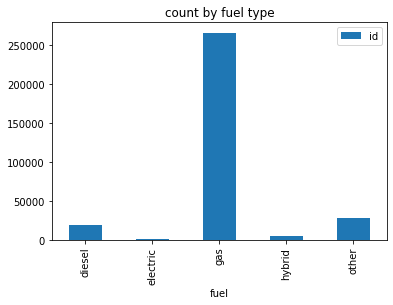

In [10]:
df[['fuel','id']].groupby('fuel').count().plot(kind='bar', title="count by fuel type")

In [11]:
df['transmission'].unique()

array(['other', 'automatic', 'manual', nan], dtype=object)

<AxesSubplot:title={'center':'count by transmission type'}, xlabel='transmission'>

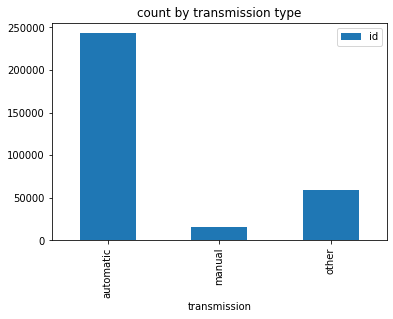

In [12]:
df[['transmission','id']].groupby('transmission').count().plot(kind='bar', title="count by transmission type")

In [13]:
df['drive'].unique()

array([nan, 'rwd', '4wd', 'fwd'], dtype=object)

<AxesSubplot:title={'center':'count by drive type'}, xlabel='drive'>

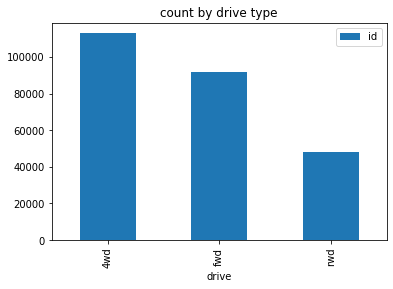

In [14]:
df[['drive','id']].groupby('drive').count().plot(kind='bar', title="count by drive type")

In [15]:
df['type'].unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'van', 'convertible', 'wagon',
       'bus'], dtype=object)

<AxesSubplot:title={'center':'count by vehicle type'}, xlabel='type'>

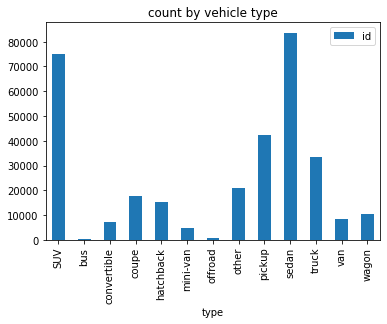

In [16]:
df[['type','id']].groupby('type').count().plot(kind='bar', title="count by vehicle type")

In [17]:
# update value 'other' to more specific value
df.loc[df[(df['fuel'] == 'other')].index,'fuel'] = 'other_fuel'
df.loc[df[(df['transmission'] == 'other')].index,'transmission'] = 'other_transmission'
df.loc[df[(df['type'] == 'other')].index,'type'] = 'other_type'

In [18]:
pd.set_option('display.max_rows', 15)

In [19]:
# convert to category columns - memory optimization

df['year'] = df['year'].astype('int16')
df['manufacturer'] = df['manufacturer'].astype('category')
df['condition'] = df['condition'].astype('category')
df['cylinders'] = df['cylinders'].astype('category')
df['fuel'] = df['fuel'].astype('category')
df['transmission'] = df['transmission'].astype('category')
df['drive'] = df['drive'].astype('category')
df['size'] = df['size'].astype('category')
df['type'] = df['type'].astype('category')
df['state'] = df['state'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319544 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            319544 non-null  object  
 1   price         319544 non-null  float64 
 2   year          319544 non-null  int16   
 3   manufacturer  319544 non-null  category
 4   model         316647 non-null  object  
 5   condition     209929 non-null  category
 6   cylinders     212362 non-null  category
 7   fuel          317862 non-null  category
 8   odometer      319544 non-null  float64 
 9   transmission  317986 non-null  category
 10  drive         252879 non-null  category
 11  size          110847 non-null  category
 12  type          319544 non-null  category
 13  state         319544 non-null  category
dtypes: category(9), float64(2), int16(1), object(2)
memory usage: 25.5+ MB


### regression model notes
* price is going to be our target variable 
* odometer reading will be broken down into bins 

In [20]:
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('^display.', silent=True)

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,319544.00,39773.08,7347842.21,0.00,6695.00,15000.00,27590.00,3736928711.00
year,319544.00,2012.20,8.08,1900.00,2010.00,2014.00,2017.00,2022.00
odometer,319544.00,90087.64,163640.07,0.00,34605.00,79845.50,127222.25,10000000.00


In [22]:
# use clip function to drop price below 100 and above 100000  
df = df[(df['price'] >= 100) & (df['price'] <= 100000)]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,293744.00,19739.10,14239.52,100.00,8228.00,16988.00,28590.00,100000.00
year,293744.00,2012.02,8.21,1900.00,2009.00,2014.00,2017.00,2022.00
odometer,293744.00,90605.27,148143.81,0.00,34484.75,80731.50,129179.00,10000000.00


<AxesSubplot:title={'center':'distribution price over year'}, xlabel='year', ylabel='price'>

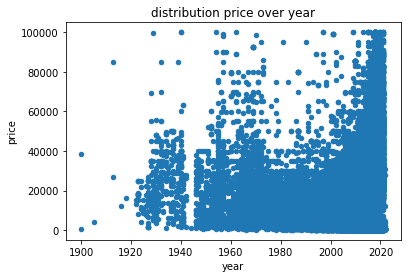

In [23]:
#scatter plot of price vs. year 
df.plot(kind="scatter", x="year", y="price", title="distribution price over year")

There seems to be a trend where car price goes down for older cars, up to a point where it starts going up again - for instance, for cars older than 1980 (classic cars). And then the price trend goes down again for antique cars - i.e. prior to 1925. We will take this into account in the regression model by creating a car_categories of: `['modern','classic','antique']` 

These will appear as features in the regression model, so in preparation for that, we will create a matrix for these categories in the existing dataframe. 

In [24]:
# would catagorizing cars as classic if built prior to 1980, 
# increase the accuracy of our model? 
df['classic_car'] = 0 
df.loc[df[(df['year'] < 1980) & (df['year'] > 1925)].index,'classic_car'] = 1

df['modern_car'] = 0 
df.loc[df[(df['year'] >= 1980)].index,'modern_car'] = 1

df['antique_car'] = 0 
df.loc[df[(df['year'] <= 1925)].index,'antique_car'] = 1

In [25]:
df[(df['year'] < 1985) & (df['year'] > 1975)].sample(20)

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,state,classic_car,modern_car,antique_car
401624,7306527823,6000.00,1982,chevrolet,el camino,excellent,8 cylinders,gas,112965.00,manual,rwd,full-size,pickup,wa,0,1,0
384928,7302478921,14900.00,1984,ford,bronco,good,8 cylinders,gas,70350.00,automatic,4wd,full-size,offroad,tx,0,1,0
224364,7308691862,22500.00,1976,ford,f250,excellent,8 cylinders,gas,5000.00,manual,4wd,full-size,pickup,mt,1,0,0
377365,7304932506,6500.00,1978,chevrolet,corvette,good,8 cylinders,gas,50000.00,automatic,rwd,full-size,coupe,tx,1,0,0
263315,7305894482,14000.00,1983,chevrolet,g20 van,good,8 cylinders,gas,37227.00,automatic,rwd,full-size,van,nm,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336693,7312785589,10000.00,1979,chevrolet,corvette stingray,excellent,8 cylinders,gas,59000.00,automatic,rwd,NaN,coupe,pa,1,0,0
312684,7311028388,12000.00,1976,jeep,NaN,excellent,8 cylinders,gas,4000.00,automatic,4wd,NaN,offroad,or,1,0,0
26902,7312555674,29000.00,1980,pontiac,firebird,good,8 cylinders,gas,69068.00,automatic,rwd,mid-size,coupe,ca,0,1,0
83441,7302187945,10000.00,1982,chevrolet,scottsdale,good,8 cylinders,gas,36000.00,automatic,rwd,full-size,truck,ct,0,1,0


In [26]:
# Check "correlations"
corrs = df.corr()
corrs['price'].sort_values()

odometer      -0.24
classic_car   -0.01
antique_car   -0.00
modern_car     0.01
year           0.41
price          1.00
Name: price, dtype: float64

car type is apparently not so much a factor

In [27]:
df['odometer'].isna().sum()

0

In [28]:
df[df['odometer'] <= 10]['odometer'].count()

2157

In [29]:
# odo is required, drop odo of 10 miles or less
df = df[df['odometer'] > 10]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,291587.00,19782.79,14201.23,100.00,8450.00,16990.00,28590.00,100000.00
year,291587.00,2012.05,8.07,1900.00,2009.00,2014.00,2017.00,2022.00
odometer,291587.00,91275.50,148484.89,11.00,35200.00,81481.00,129701.00,10000000.00
classic_car,291587.00,0.01,0.11,0.00,0.00,0.00,0.00,1.00
modern_car,291587.00,0.99,0.11,0.00,1.00,1.00,1.00,1.00
antique_car,291587.00,0.00,0.01,0.00,0.00,0.00,0.00,1.00


In [30]:
# create bins for odometer
df['odometer_cat'] = pd.cut(df["odometer"], 
                  bins=[0, 10000, 25000, 50000, 80000, 100000, 150000, 200000, 250000, 500000, 750000, np.inf], 
                  labels=['  0-010k',' 10k-25k',' 25k-50k',' 50k-80k',' 80k-100k','100k-150k','150k-200k',
                              '200k-250k','250k-500k','500k-750k','750k+']).copy()

df['odometer_cat'] = df['odometer_cat'].astype('category')

df['odometer_cat'].describe().T

C:\Users\dgouin\AppData\Local\Temp\ipykernel_7340\1214466414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['odometer_cat'] = pd.cut(df["odometer"],
C:\Users\dgouin\AppData\Local\Temp\ipykernel_7340\1214466414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['odometer_cat'] = df['odometer_cat'].astype('category')


count        291587
unique           11
top       100k-150k
freq          67291
Name: odometer_cat, dtype: object

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291587 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            291587 non-null  object  
 1   price         291587 non-null  float64 
 2   year          291587 non-null  int16   
 3   manufacturer  291587 non-null  category
 4   model         289212 non-null  object  
 5   condition     199425 non-null  category
 6   cylinders     196038 non-null  category
 7   fuel          289954 non-null  category
 8   odometer      291587 non-null  float64 
 9   transmission  290231 non-null  category
 10  drive         230498 non-null  category
 11  size          100086 non-null  category
 12  type          291587 non-null  category
 13  state         291587 non-null  category
 14  classic_car   291587 non-null  int64   
 15  modern_car    291587 non-null  int64   
 16  antique_car   291587 non-null  int64   
 17  odometer_cat  291587 non-nul

### Fill in the data gaps
1. `model` missing for some records. However, there are over 20k different model descriptions. It is so granular, it should probably be examine further to categorize in fewer categories? For now, will rely only on manufacturer for initial iteration of the regression
1. condition will default to `good` 
1. cylinders will ignore for now and exclude from the regression model 
1. fuel - will default to `gas` 
1. transmission will default to `automatic` 
1. size has a lot of missing records... will ignore and only rely on type 

In [32]:
# condition 
df['condition'].fillna('excellent', inplace=True)
df['condition'].unique()


C:\Users\dgouin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\series.py:4530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


['good', 'excellent', 'fair', 'like new', 'new', 'salvage']
Categories (6, object): ['good', 'excellent', 'fair', 'like new', 'new', 'salvage']

<AxesSubplot:title={'center':'count by condition type (after filling in NaN)'}, xlabel='condition'>

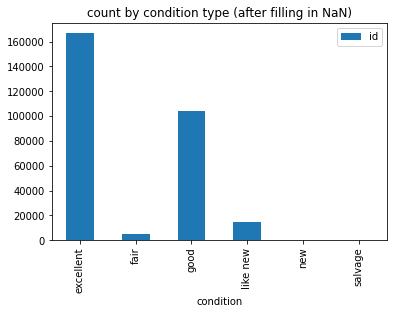

In [33]:
df[['condition','id']].groupby('condition').count().plot(kind='bar', title="count by condition type (after filling in NaN)")

In [34]:
# fuel
df['fuel'].fillna('gas', inplace=True)
df['fuel'].unique()


['gas', 'other_fuel', 'diesel', 'hybrid', 'electric']
Categories (5, object): ['gas', 'other_fuel', 'diesel', 'hybrid', 'electric']

<AxesSubplot:title={'center':'count by fuel type (after filling in NaN)'}, xlabel='fuel'>

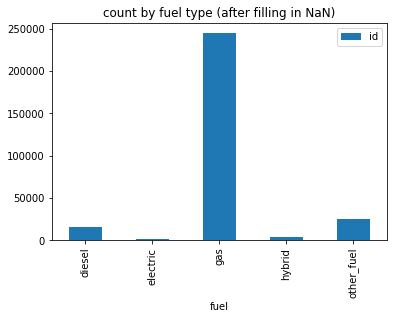

In [35]:
df[['fuel','id']].groupby('fuel').count().plot(kind='bar', title="count by fuel type (after filling in NaN)")

In [36]:
# transmission
df['transmission'].fillna('automatic', inplace=True)
df['transmission'].unique()


['other_transmission', 'automatic', 'manual']
Categories (3, object): ['other_transmission', 'automatic', 'manual']

<AxesSubplot:title={'center':'count by transmission type (after filling in NaN)'}, xlabel='transmission'>

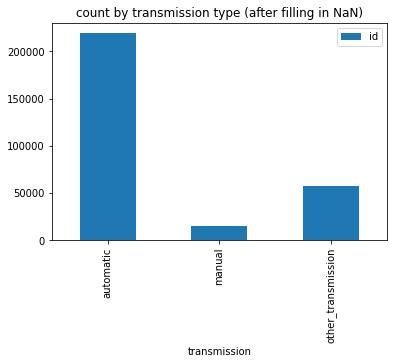

In [37]:
df[['transmission','id']].groupby('transmission').count().plot(kind='bar', title="count by transmission type (after filling in NaN)")

In [38]:
# drive
df['drive'].fillna('fwd', inplace=True)
df['drive'].unique()

['fwd', 'rwd', '4wd']
Categories (3, object): ['fwd', 'rwd', '4wd']

<AxesSubplot:title={'center':'count by drive type (after filling in NaN)'}, xlabel='drive'>

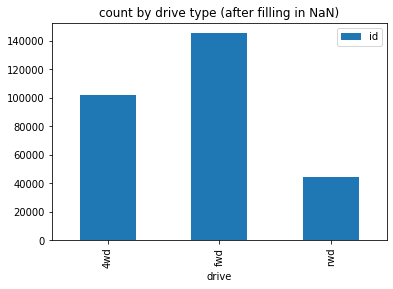

In [39]:
df[['drive','id']].groupby('drive').count().plot(kind='bar', title="count by drive type (after filling in NaN)")

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291587 entries, 27 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            291587 non-null  object  
 1   price         291587 non-null  float64 
 2   year          291587 non-null  int16   
 3   manufacturer  291587 non-null  category
 4   model         289212 non-null  object  
 5   condition     291587 non-null  category
 6   cylinders     196038 non-null  category
 7   fuel          291587 non-null  category
 8   odometer      291587 non-null  float64 
 9   transmission  291587 non-null  category
 10  drive         291587 non-null  category
 11  size          100086 non-null  category
 12  type          291587 non-null  category
 13  state         291587 non-null  category
 14  classic_car   291587 non-null  int64   
 15  modern_car    291587 non-null  int64   
 16  antique_car   291587 non-null  int64   
 17  odometer_cat  291587 non-nul

### Setup data for regression modeling 

In [50]:
# create model for state of california
df_model = df[df['state'] == 'ca'][['price',
              'year',
             'manufacturer',
              'condition',
              'fuel',
              'odometer_cat',
              'transmission',
              'drive',
              'type',
#               'state',
              'classic_car',
              'modern_car',
              'antique_car']]

In [51]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   price         33956 non-null  float64 
 1   year          33956 non-null  int16   
 2   manufacturer  33956 non-null  category
 3   condition     33956 non-null  category
 4   fuel          33956 non-null  category
 5   odometer_cat  33956 non-null  category
 6   transmission  33956 non-null  category
 7   drive         33956 non-null  category
 8   type          33956 non-null  category
 9   classic_car   33956 non-null  int64   
 10  modern_car    33956 non-null  int64   
 11  antique_car   33956 non-null  int64   
dtypes: category(7), float64(1), int16(1), int64(3)
memory usage: 1.6 MB


In [52]:
df_model = pd.get_dummies(df_model, columns = list(df_model.select_dtypes(include='category')), prefix='', prefix_sep='')

In [53]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 88 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               33956 non-null  float64
 1   year                33956 non-null  int16  
 2   classic_car         33956 non-null  int64  
 3   modern_car          33956 non-null  int64  
 4   antique_car         33956 non-null  int64  
 5   acura               33956 non-null  uint8  
 6   alfa-romeo          33956 non-null  uint8  
 7   aston-martin        33956 non-null  uint8  
 8   audi                33956 non-null  uint8  
 9   bmw                 33956 non-null  uint8  
 10  buick               33956 non-null  uint8  
 11  cadillac            33956 non-null  uint8  
 12  chevrolet           33956 non-null  uint8  
 13  chrysler            33956 non-null  uint8  
 14  datsun              33956 non-null  uint8  
 15  dodge               33956 non-null  uint8  
 16  

In [54]:
df_model.shape

(33956, 88)

In [55]:
df_model.sample(25)

,price,year,classic_car,modern_car,antique_car,acura,alfa-romeo,aston-martin,audi,bmw,...,coupe,hatchback,mini-van,offroad,other_type,pickup,sedan,truck,van,wagon
58650,29777.00,2016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
66576,10999.00,2011,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
57153,33590.00,2016,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
45006,8995.00,2016,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
40854,14590.00,2012,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29239,8400.00,1973,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37194,10499.00,2008,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
63260,31990.00,2019,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
56990,24495.00,2016,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# sample complete model data set 
with open('./df_model.pkl', 'wb') as handle:
    pickle.dump(df_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
# Check "correlations" again
corrs = df_model.corr()
corr_factors = corrs['price'].sort_values()

pd.set_option('display.max_rows', None)
print(corr_factors)
pd.set_option('display.max_rows', 10)


gas                  -0.28
100k-150k            -0.27
150k-200k            -0.24
fwd                  -0.23
automatic            -0.21
sedan                -0.21
200k-250k            -0.15
fair                 -0.14
honda                -0.10
excellent            -0.10
250k-500k            -0.09
hatchback            -0.09
nissan               -0.09
manual               -0.09
hyundai              -0.08
mini-van             -0.07
 80k-100k            -0.07
wagon                -0.06
volkswagen           -0.06
kia                  -0.05
toyota               -0.05
chrysler             -0.05
salvage              -0.05
mercury              -0.04
saturn               -0.04
SUV                  -0.04
subaru               -0.04
mazda                -0.04
dodge                -0.04
hybrid               -0.03
mitsubishi           -0.03
pontiac              -0.03
mini                 -0.03
modern_car           -0.02
fiat                 -0.02
750k+                -0.02
buick                -0.02
o

C:\Users\dgouin\AppData\Local\Temp\ipykernel_7340\1543825126.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(corrs[abs(corr_factors) >= .1]);


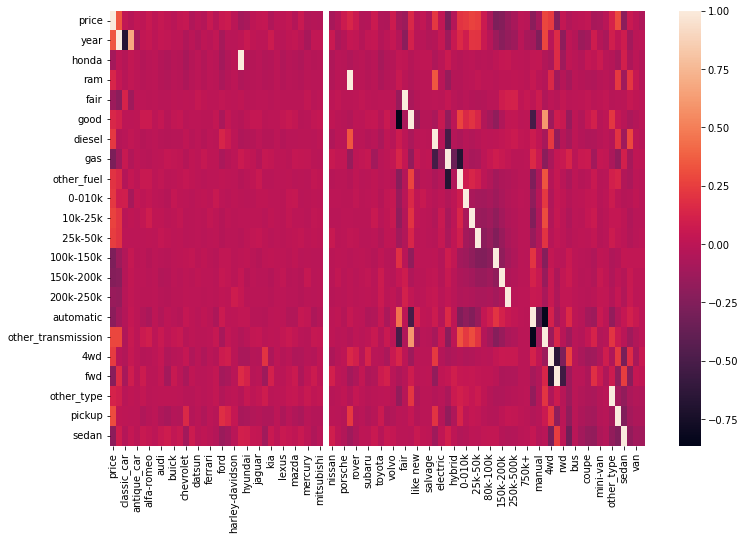

In [48]:
# heatmap correlations
plt.figure(figsize=(12,8))
sns.heatmap(corrs[abs(corr_factors) >= .1]);

In [49]:
# retain columns with correlation factors outside -.1 to .1 as features 
feature_list = corr_factors.loc[abs(corr_factors) >= .1].index.tolist()

feature_list

['gas',
 '100k-150k',
 '150k-200k',
 'fwd',
 'automatic',
 'sedan',
 '200k-250k',
 'fair',
 'honda',
 'other_type',
 'ram',
 'good',
 'other_fuel',
 '  0-010k',
 'diesel',
 '4wd',
 ' 25k-50k',
 ' 10k-25k',
 'other_transmission',
 'pickup',
 'year',
 'price']

In [50]:
# restrict to relevant features
df_model = df_model[feature_list].copy()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33956 entries, 21171 to 71784
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gas                 33956 non-null  uint8  
 1   100k-150k           33956 non-null  uint8  
 2   150k-200k           33956 non-null  uint8  
 3   fwd                 33956 non-null  uint8  
 4   automatic           33956 non-null  uint8  
 5   sedan               33956 non-null  uint8  
 6   200k-250k           33956 non-null  uint8  
 7   fair                33956 non-null  uint8  
 8   honda               33956 non-null  uint8  
 9   other_type          33956 non-null  uint8  
 10  ram                 33956 non-null  uint8  
 11  good                33956 non-null  uint8  
 12  other_fuel          33956 non-null  uint8  
 13    0-010k            33956 non-null  uint8  
 14  diesel              33956 non-null  uint8  
 15  4wd                 33956 non-null  uint8  
 16  

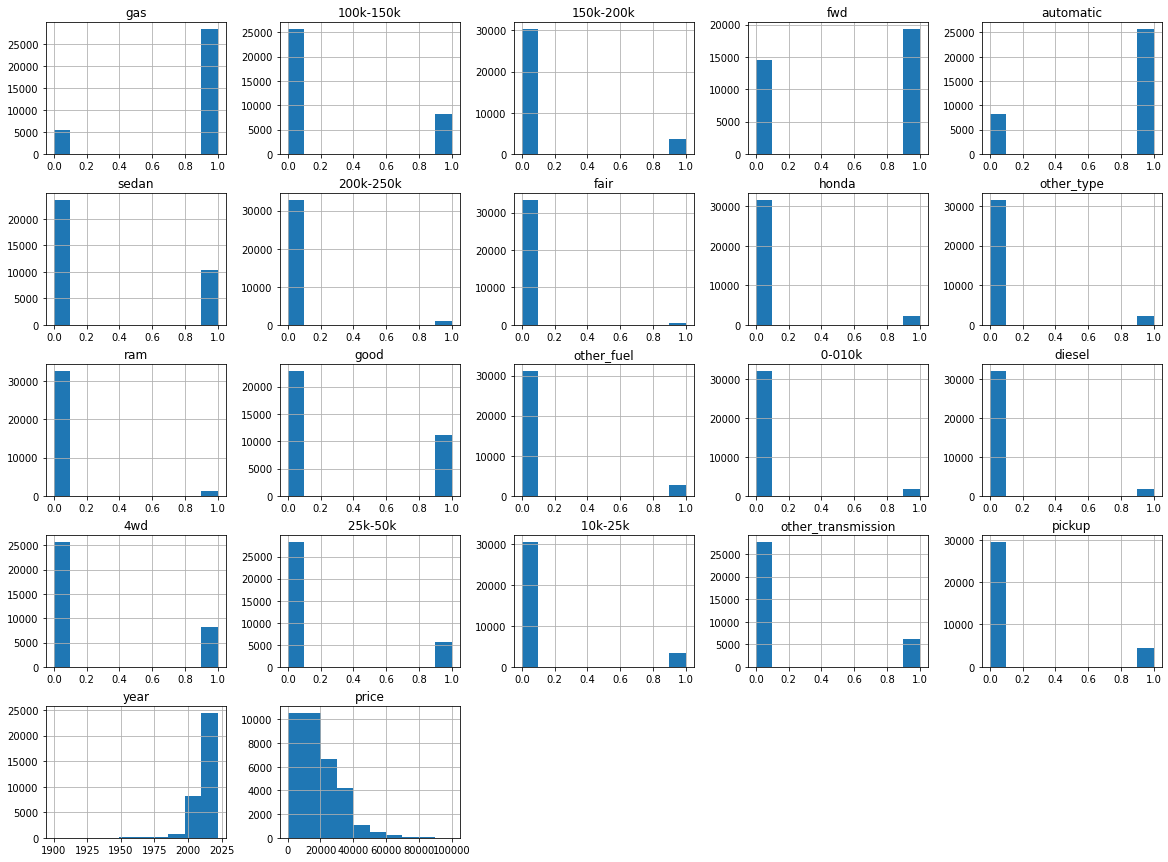

In [51]:
# distribution by feature 
fig = df_model.hist(bins=10, figsize=(20,15))

In [52]:
df_model.reset_index
df_model.head()

,gas,100k-150k,150k-200k,fwd,automatic,sedan,200k-250k,fair,honda,other_type,...,other_fuel,0-010k,diesel,4wd,25k-50k,10k-25k,other_transmission,pickup,year,price
21171,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,2018,16990.00
21174,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,2003,11975.00
21176,0,0,0,0,1,0,1,0,0,0,...,0,0,1,1,0,0,0,0,2003,21950.00
21178,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,2018,27590.00
21179,1,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,2018,21990.00


In [53]:
df_model.sample(15)

,gas,100k-150k,150k-200k,fwd,automatic,sedan,200k-250k,fair,honda,other_type,...,other_fuel,0-010k,diesel,4wd,25k-50k,10k-25k,other_transmission,pickup,year,price
58650,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,2016,29777.00
66576,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2011,10999.00
57153,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,2016,33590.00
45006,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2016,8995.00
40854,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,2012,14590.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67574,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2014,8999.00
45378,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2005,14900.00
26119,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2014,14700.00
24015,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2004,15999.00


In [54]:
df_model.isna().sum().sum()

0

### Model Building

In [55]:
# declare target variable
y = df_model['price']
y.shape

(33956,)

In [56]:
X = df_model.drop(['price'], axis=1)
X.shape

(33956, 21)

In [57]:
list(X.columns)

['gas',
 '100k-150k',
 '150k-200k',
 'fwd',
 'automatic',
 'sedan',
 '200k-250k',
 'fair',
 'honda',
 'other_type',
 'ram',
 'good',
 'other_fuel',
 '  0-010k',
 'diesel',
 '4wd',
 ' 25k-50k',
 ' 10k-25k',
 'other_transmission',
 'pickup',
 'year']

In [58]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 30)

### Linear regression model

In [59]:
# Instantiate the SKlearn algorithm
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
mymodel = LinearRegression(fit_intercept=True, 
#                            normalize=False, # deprecated
                           copy_X=True, 
                           n_jobs=None, 
                           positive=False)

In [60]:
# Fit the model to the training dataset
mymodel.fit(X_train, y_train)

LinearRegression()

In [61]:
# what is the intercept? (the value when all predictors are zero)
mymodel.intercept_

-455904.52509993606

In [62]:
# what are the coefficients?
pd.options.display.float_format = '{:.5f}'.format
list(mymodel.coef_)

[1206.524841881094,
 -5328.567356322737,
 -8388.956257931755,
 -4604.431858123659,
 397.3097258338783,
 -2127.7428177918864,
 -10226.96459157207,
 -6567.205494203253,
 -391.8923468508713,
 4021.3628948208952,
 -167.42906033016746,
 -1052.4753701198345,
 4288.053058444601,
 12355.40614055657,
 11697.949756776563,
 2494.1128097533333,
 6462.403062965344,
 9520.23928664581,
 1336.1929534715086,
 7100.340355415625,
 235.67980620625846]

### Feature Scaling

In [63]:
X_train.describe().columns

Index(['gas', '100k-150k', '150k-200k', 'fwd', 'automatic', 'sedan',
       '200k-250k', 'fair', 'honda', 'other_type', 'ram', 'good', 'other_fuel',
       '  0-010k', 'diesel', '4wd', ' 25k-50k', ' 10k-25k',
       'other_transmission', 'pickup', 'year'],
      dtype='object')

Standardization

In [64]:
std_scaler = StandardScaler()
std_scaler = std_scaler.fit(X_train.values)
X_train_scaled = std_scaler.transform(X_train.values)
X_train_scaled[0]

array([ 0.43664488, -0.56430548, -0.34029275,  0.86509344,  0.5617047 ,
       -0.65844446, -0.17857259, -0.12224975, -0.26870885, -0.2746254 ,
       -0.19140144, -0.69408895, -0.29564155, -0.23926643, -0.22786113,
       -0.56285393, -0.4425589 , -0.33087736, -0.47163074, -0.3848286 ,
       -0.63894442])

In [65]:
X_test_scaled = std_scaler.transform(X_test.values)
X_test_scaled[0]

array([ 0.43664488,  1.77208984, -0.34029275, -1.1559445 ,  0.5617047 ,
       -0.65844446, -0.17857259, -0.12224975, -0.26870885, -0.2746254 ,
       -0.19140144, -0.69408895, -0.29564155, -0.23926643, -0.22786113,
        1.77665988, -0.4425589 , -0.33087736, -0.47163074,  2.59855949,
       -0.63894442])

### Select and train a model

#### Linear regression

In [66]:
# Create a local instance of the sklearn class
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train_scaled, y_train)
lin_reg.intercept_

18909.853182549992

In [67]:
# scaled features relative importance - as all are now on a comparable scale 
lin_reg.coef_

array([  442.46337831, -2280.67884129, -2558.43626527, -2278.25107818,
         169.64551488,  -977.29507004, -1769.81922284,  -791.01749875,
         -98.21349105,  1026.9190828 ,   -30.91365595,  -493.00277054,
        1165.82866361,  2796.158218  ,  2533.94390785,  1066.08167836,
        2391.58250259,  2839.19687908,   515.5197528 ,  2379.95867578,
        2061.56133493])

In [68]:
# let's take a look at the results
feature_imp = pd.DataFrame(list(zip(X_test.columns, lin_reg.coef_)), columns=['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
150k-200k,-2558.43627
100k-150k,-2280.67884
fwd,-2278.25108
200k-250k,-1769.81922
sedan,-977.29507
...,...
pickup,2379.95868
25k-50k,2391.58250
diesel,2533.94391


In [69]:
feature_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
coeffs,21.00000,386.24913,1742.78759,-2558.43627,-791.01750,442.46338,2061.56133,2839.19688


In [108]:
# feature_imp.plot(kind='bar', title="features in order of importance ")

data = go.Bar(x=list(feature_imp.index), y=feature_imp['coeffs'])
mylayout = go.Layout(title = 'Prediction Model Feature list ordered by their impact on price prediction', 
                     xaxis = dict(title='features'), 
                     yaxis = dict(title='standardized (scaled) coefficients')) 
coefs = go.Figure([data],mylayout)
coefs


Feature interpretation:  
- mileage between 100k and 200k has the highest negative impact on price 
- front wheel drive (fwd) also have a negative impact on price - less popular with buyers
- sedan are also are the less popular type 
- condition of fair and good have a negative impact on price 
- pickup, diesel and low mileage car have the highest positive impact on price 

Make model predictions

In [71]:
y_preds = lin_reg.predict(X_test_scaled)
y_preds

array([22738.88652638, 14097.62410368, 30257.67426473, ...,
       21952.60475497,  8533.37694115, 11166.33484585])

In [72]:
num_pred = 10
true_y = list(round(y_test[:num_pred], 1))
pred_y = [round(x,1) for x in list(y_preds[:num_pred])]

In [73]:
pred_summary = pd.DataFrame(list(zip(true_y, pred_y)), columns=['true', 'predicted'])
pred_summary['over/under'] = pred_summary['predicted'].sub(pred_summary['true'])
pred_summary

,true,predicted,over/under
0,18995.00000,22738.90000,3743.90000
1,34998.00000,14097.60000,-20900.40000
2,51995.00000,30257.70000,-21737.30000
3,36990.00000,31897.30000,-5092.70000
4,19985.00000,13756.60000,-6228.40000
5,9000.00000,15282.60000,6282.60000
6,16900.00000,30493.40000,13593.40000
7,5990.00000,14350.40000,8360.40000
8,4000.00000,9216.30000,5216.30000
9,30622.00000,23146.50000,-7475.50000


In [74]:
pred_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
true,10.00000,22947.50000,15445.71066,4000.00000,10975.00000,19490.00000,33904.00000,51995.00000
predicted,10.00000,20523.73000,8271.87405,9216.30000,14160.80000,19010.75000,28479.90000,31897.30000
over/under,10.00000,-2423.77000,12048.86546,-21737.30000,-7163.72500,-674.40000,6016.02500,13593.40000


Evaluate the model

In [75]:
# Root mean square (RMSE)
rmse_ols = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
rmse_ols = int(rmse_ols)
rmse_ols

9297

In [76]:
# R-squared
r2_ols=metrics.r2_score(y_test, y_preds)
r2_ols=round(r2_ols, 2)
r2_ols

0.52

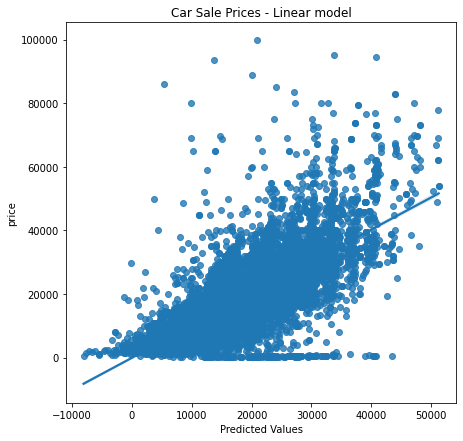

In [77]:
# Visualize our true vs. predicted values
plt.figure(figsize=(7,7))
plt.title('Car Sale Prices - Linear model')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

#### Ridget Regression

In [78]:
# Create a local instance of the sklearn class
ridge_model = linear_model.Ridge(alpha=.5)

# Fit your instance to the training dataset
ridge_model.fit(X_train_scaled, y_train)

# Make predictions on the testing dataset
y_preds = ridge_model.predict(X_test_scaled)

# root mean squared error represents the average error (in $) of our model
ridge_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

# R-squared is the proportion of the variance in the DV that's explained by the model
ridge_r2=round(metrics.r2_score(y_test, y_preds),2)
print(ridge_rmse, ridge_r2)

9297 0.52


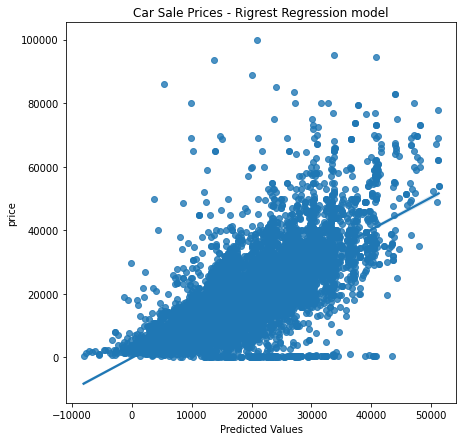

In [79]:
# Visualize our true vs. predicted values
plt.figure(figsize=(7,7))
plt.title('Car Sale Prices - Rigrest Regression model')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

#### K-Nearest Neighbors Regression

In [80]:
# Create a local instance of the sklearn class
knn_model = KNeighborsRegressor(n_neighbors=8)

# Fit your instance to the training dataset
knn_model.fit(X_train_scaled, y_train)

# Make predictions on the testing dataset
y_preds = knn_model.predict(X_test_scaled)

# root mean squared error represents the average error (in $) of our model
knn_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

# R-squared is the proportion of the variance in the DV that's explained by the model
knn_r2=round(metrics.r2_score(y_test, y_preds),2)
print(knn_rmse, knn_r2)

8140 0.63


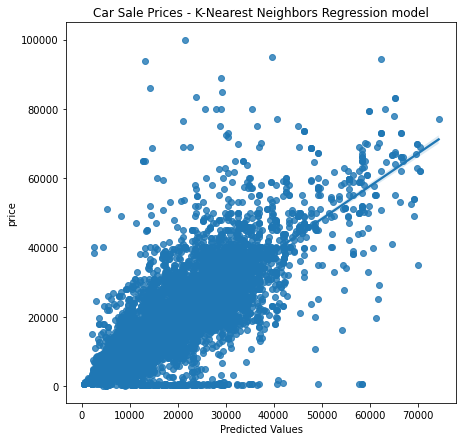

In [81]:
# Visualize our true vs. predicted values
plt.figure(figsize=(7,7))
plt.title('Car Sale Prices - K-Nearest Neighbors Regression model')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

#### Decision Tree Regression

In [82]:
# Create a local instance of the sklearn class
tree_model = DecisionTreeRegressor(max_depth=9)

# Fit your instance to the training dataset
tree_model.fit(X_train_scaled, y_train)

# Make predictions on the testing dataset
y_preds = tree_model.predict(X_test_scaled)

# root mean squared error represents the average error (in $) of our model
tree_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

# R-squared is the proportion of the variance in the DV that's explained by the model
tree_r2=round(metrics.r2_score(y_test, y_preds),2)
print(tree_rmse, tree_r2)

8349 0.61


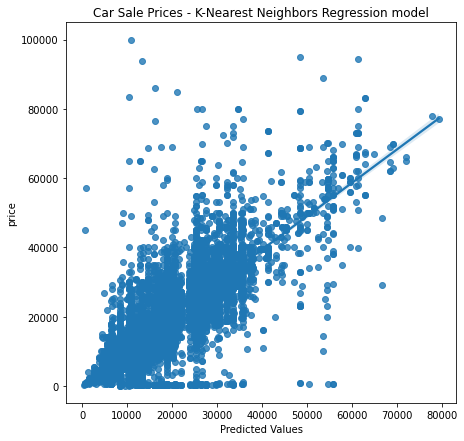

In [83]:
# Visualize our true vs. predicted values
plt.figure(figsize=(7,7))
plt.title('Car Sale Prices - K-Nearest Neighbors Regression model')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

#### Random Forest Regression

In [84]:
# Create a local instance of the sklearn class
forest_model = RandomForestRegressor(max_depth=10, n_estimators=200)

# Fit your instance to the training dataset
forest_model.fit(X_train_scaled, y_train)

# Make predictions on the testing dataset
y_preds = forest_model.predict(X_test_scaled)

# root mean squared error represents the average error (in $) of our model
forest_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))

# R-squared is the proportion of the variance in the DV that's explained by the model
forest_r2=round(metrics.r2_score(y_test, y_preds),2)
print(forest_rmse, forest_r2)

7934 0.65


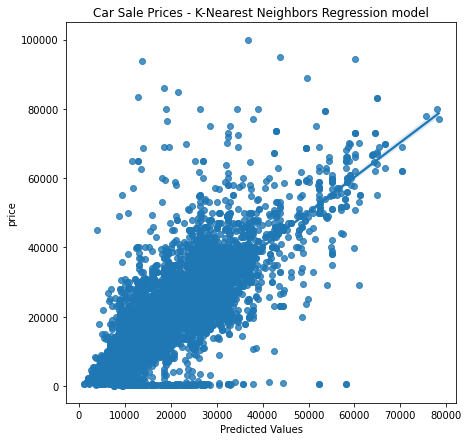

In [85]:
# Visualize our true vs. predicted values
plt.figure(figsize=(7,7))
plt.title('Car Sale Prices - K-Nearest Neighbors Regression model')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

#### Compare regression models

In [86]:
# Compare OLS Linear Regression to the Baseline

evaluation_df2 = pd.DataFrame([ 
                              ['OLS Linear Regression', rmse_ols, r2_ols],
                              ['Ridge Regession', ridge_rmse, ridge_r2],
                              ['K-Nearest Neighbors Regression', knn_rmse, knn_r2],
                              ['Decision Tree Regression', tree_rmse, tree_r2],
                              ['Random Forest Regression', forest_rmse, forest_r2]], 
                             columns=['Model','RMSE','R-squared']
                            )
evaluation_df2.set_index('Model', inplace=True)
evaluation_df2

,RMSE,R-squared
Model,,
OLS Linear Regression,9297,0.52000
Ridge Regession,9297,0.52000
K-Nearest Neighbors Regression,8140,0.63000
Decision Tree Regression,8349,0.61000
Random Forest Regression,7934,0.65000


In [87]:
# Bar chart with plotly: RMSE
trace = go.Bar(x=list(evaluation_df2.index), 
               y=evaluation_df2['RMSE'], 
                marker=dict(color=['#ebc83d','#badf55', '#35b1c9','#b06dad','#e96060', '#1e1d69'])
              )
layout = go.Layout(title = 'Model Comparison: Root Mean Squared Error', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'RMSE'), # y-axis label  
                  ) 

rmse_fig = go.Figure(data = [trace], layout=layout)
rmse_fig

In [88]:
# Bar chart with plotly: R-Squared
trace = go.Bar(x=list(evaluation_df2.index), 
               y=evaluation_df2['R-squared'], 
                marker=dict(color=['#ebc83d','#badf55', '#35b1c9','#b06dad','#e96060', '#1e1d69']),
              )
layout = go.Layout(title = 'Model Comparison: R-Squared', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'R-Squared'), # y-axis label  
                  ) 

r2_fig = go.Figure(data = [trace], layout=layout)
r2_fig

Observation:
* OLS and Ridge regression returned similar results 
* OLS and Ridge regression have the lowest R-Squaredbut a higher price error based on RMSE 

### App Prep

Some variables that will be needed to implement car sale price forecasting model

In [89]:
X.columns

Index(['gas', '100k-150k', '150k-200k', 'fwd', 'automatic', 'sedan',
       '200k-250k', 'fair', 'honda', 'other_type', 'ram', 'good', 'other_fuel',
       '  0-010k', 'diesel', '4wd', ' 25k-50k', ' 10k-25k',
       'other_transmission', 'pickup', 'year'],
      dtype='object')

In [109]:
# prepare dict object to export model info

# predictor model
predictor_model = {"predictor_vars": X.columns, 
                   "predictor_target": y.name}

# predictor_model['std_scaler'] = std_scaler 
predictor_model['coeff_go_fig'] = coefs
predictor_model['rmse_go_fig'] = rmse_fig
predictor_model['r2_go_fig'] = r2_fig
# predictor_model['lin_reg'] = lin_reg

model_data = {
    'intercept': lin_reg.intercept_,
    'coeff': lin_reg.coef_
}
predictor_model['lin_reg'] = model_data

pp(predictor_model)

{'predictor_vars': Index(['gas', '100k-150k', '150k-200k', 'fwd', 'automatic', 'sedan',
       '200k-250k', 'fair', 'honda', 'other_type', 'ram', 'good', 'other_fuel',
       '  0-010k', 'diesel', '4wd', ' 25k-50k', ' 10k-25k',
       'other_transmission', 'pickup', 'year'],
      dtype='object'),
 'predictor_target': 'price',
 'coeff_go_fig': Figure({
    'data': [{'type': 'bar',
              'x': [150k-200k, 100k-150k, fwd, 200k-250k, sedan, fair, good,
                    honda, ram, automatic, gas, other_transmission, other_type,
                    4wd, other_fuel, year, pickup,  25k-50k, diesel,   0-010k,
                    10k-25k],
              'y': array([-2558.43626527, -2280.67884129, -2278.25107818, -1769.81922284,
                           -977.29507004,  -791.01749875,  -493.00277054,   -98.21349105,
                            -30.91365595,   169.64551488,   442.46337831,   515.5197528 ,
                           1026.9190828 ,  1066.08167836,  1165.82866361,  2061.

#### save objects

In [106]:
with open('./components_data/std_scaler.pkl', 'wb') as handle:
    pickle.dump(std_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./components_data/lin_reg.pkl', 'wb') as handle:
    pickle.dump(lin_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./components_data/predictor_model.pkl', 'wb') as handle:
    pickle.dump(predictor_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
# test reopen
with open('./components_data/predictor_model.pkl', 'rb') as f:
    reopen_predictor_model = pickle.load(f)
reopen_predictor_model['rmse_go_fig']

#### Setup category lists

In [93]:
print(list(df['fuel'].unique()))

['gas', 'other_fuel', 'diesel', 'hybrid', 'electric']


In [94]:
print(f"'fuel_type': {list(df['fuel'].unique())},")
print(f"'transmission': {list(df['transmission'].unique())},")
print(f"'drive': {list(df['drive'].unique())},")
print(f"car_type': {list(df['type'].unique())},"),
print(f"'car_condition': {list(df['condition'].unique())}")
print(f"'odometer_cat': {list(df['odometer_cat'].unique())}")

'fuel_type': ['gas', 'other_fuel', 'diesel', 'hybrid', 'electric'],
'transmission': ['other_transmission', 'automatic', 'manual'],
'drive': ['fwd', 'rwd', '4wd'],
car_type': ['pickup', 'truck', 'other_type', 'coupe', 'SUV', 'hatchback', 'mini-van', 'sedan', 'offroad', 'convertible', 'wagon', 'van', 'bus'],
'car_condition': ['good', 'excellent', 'fair', 'like new', 'new', 'salvage']
'odometer_cat': [' 50k-80k', ' 10k-25k', ' 25k-50k', '100k-150k', '  0-010k', ' 80k-100k', '150k-200k', '200k-250k', '250k-500k', '750k+', '500k-750k']


In [95]:
df['odometer_cat'].unique()

[' 50k-80k', ' 10k-25k', ' 25k-50k', '100k-150k', '  0-010k', ..., '150k-200k', '200k-250k', '250k-500k', '750k+', '500k-750k']
Length: 11
Categories (11, object): ['  0-010k' < ' 10k-25k' < ' 25k-50k' < ' 50k-80k' ... '200k-250k' < '250k-500k' < '500k-750k' < '750k+']

In [96]:
# manually copy / paste cat list and reorder items
app_categories = {
    'fuel_type': ['gas', 'diesel', 'other_fuel', 'hybrid', 'electric'],
    'transmission': ['automatic', 'manual', 'other_transmission'],
    'drive': ['fwd', 'rwd', '4wd'],
    'car_type': [ 'sedan', 'coupe', 'convertible','hatchback', 
                 'wagon','mini-van', 'van', 'bus','SUV', 'pickup', 'truck',
                 'offroad', 'other_type'],
    'car_condition': ['new', 'like new', 'excellent','good', 'fair',  'salvage'],
    'odometer_cat': [' 0-010k', ' 10k-25k', ' 25k-50k', ' 50k-80k', ' 80k-100k', '100k-150k', 
                      '150k-200k', '200k-250k', '250k-500k', '500k-750k', '750k+'] 
}

pp(app_categories)

{'fuel_type': ['gas', 'diesel', 'other_fuel', 'hybrid', 'electric'],
 'transmission': ['automatic', 'manual', 'other_transmission'],
 'drive': ['fwd', 'rwd', '4wd'],
 'car_type': ['sedan',
              'coupe',
              'convertible',
              'hatchback',
              'wagon',
              'mini-van',
              'van',
              'bus',
              'SUV',
              'pickup',
              'truck',
              'offroad',
              'other_type'],
 'car_condition': ['new', 'like new', 'excellent', 'good', 'fair', 'salvage'],
 'odometer_cat': [' 0-010k',
                  ' 10k-25k',
                  ' 25k-50k',
                  ' 50k-80k',
                  ' 80k-100k',
                  '100k-150k',
                  '150k-200k',
                  '200k-250k',
                  '250k-500k',
                  '500k-750k',
                  '750k+']}


In [97]:
with open('./components_data/app_categories.pkl', 'wb') as handle:
    pickle.dump(app_categories, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### App utils

In [98]:
# create a dictionary of model intercept and coefficient values 
def initialize_prediction_model(intercept, predictor_vars, predictor_coeff):
    predictor_model = {'intercept': intercept}
    for v in range(0,len(predictor_vars) - 1):
        predictor_model[predictor_vars[v]] = predictor_coeff[v]
    return predictor_model

# reset user input 
def reset_model_input(predictor_vars):
    model_input = {'intercept': 1}
    for v in range(0,len(predictor_vars)):
        model_input[predictor_vars[v]] = 0 
    return model_input 

# generate prediction based on user input
def generate_prediction(predictor_model, model_input):
    prediction = 0
    for i in predictor_model.keys():
        prediction += predictor_model[i] * model_input[i]
    return '{:.2f}'.format(prediction)

In [99]:
prediction_model = initialize_prediction_model(predictor_model['lin_reg']['intercept'],
                                               predictor_model['predictor_vars'],
                                               predictor_model['lin_reg']['coeff'])
print(prediction_model)

{'intercept': 18909.853182549992, 'gas': 442.4633783071757, '100k-150k': -2280.6788412913247, '150k-200k': -2558.4362652662644, 'fwd': -2278.251078178676, 'automatic': 169.6455148829993, 'sedan': -977.2950700432493, '200k-250k': -1769.819222839014, 'fair': -791.0174987479754, 'honda': -98.21349104841116, 'other_type': 1026.9190827972413, 'ram': -30.91365594867525, 'good': -493.0027705448495, 'other_fuel': 1165.8286636059615, '  0-010k': 2796.158217999485, 'diesel': 2533.9439078472788, '4wd': 1066.0816783550024, ' 25k-50k': 2391.5825025905738, ' 10k-25k': 2839.1968790824976, 'other_transmission': 515.5197528004378, 'pickup': 2379.958675783332}


In [100]:
model_input = reset_model_input(predictor_model['predictor_vars'])
print(model_input)

{'intercept': 1, 'gas': 0, '100k-150k': 0, '150k-200k': 0, 'fwd': 0, 'automatic': 0, 'sedan': 0, '200k-250k': 0, 'fair': 0, 'honda': 0, 'other_type': 0, 'ram': 0, 'good': 0, 'other_fuel': 0, '  0-010k': 0, 'diesel': 0, '4wd': 0, ' 25k-50k': 0, ' 10k-25k': 0, 'other_transmission': 0, 'pickup': 0, 'year': 0}


In [101]:
print(generate_prediction(prediction_model, model_input))

18909.85
